In [1]:
pip install bioread

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Acqknowledge file, find the csp and measure length more consistently that the eyeball

# Use Bioread to import data (pip install bioread)
# Use the trigger channel to find the CSP using a fixed time window
# Find csp start, the first +ve peak after the -ve peak
# Find csp end 
#   Linear interpolation between peaks and another between troughs gives swelling gap
#   Discard peaks and troughs that are not expanding over time
#   Spline fit between remaining peaks and another between remaining troughs
#   Plot peak spline - trough spline
#   Threshold for end of csp

# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import bioread

# Load data from binary .acq file using bioread library
# Note read-acq is for a different file format all together
acqData = bioread.read_file('CSP Example.acq')

# What does the data look like?
print('Data file summary:')
print(acqData)

# What channels (columns) have we got
print('\nChannels:')
print(acqData.channels)

Data file summary:
AcqKnowledge file (rev 45): 5 channels, 2000.0 samples/sec

Channels:
[Channel EMG RF: 434518 samples, 2000.0 samples/sec, loaded: True, Channel Force: 434518 samples, 2000.0 samples/sec, loaded: True, Channel Trigger: 434518 samples, 2000.0 samples/sec, loaded: True, Channel EMG VL: 434518 samples, 2000.0 samples/sec, loaded: True, Channel Torque: 434518 samples, 2000.0 samples/sec, loaded: True]


In [3]:
print(acqData.channels[1].data)

[1.7971436  1.7971436  1.28331226 ... 2.05405927 2.31097494 9.50461367]


Channel name: 
Force


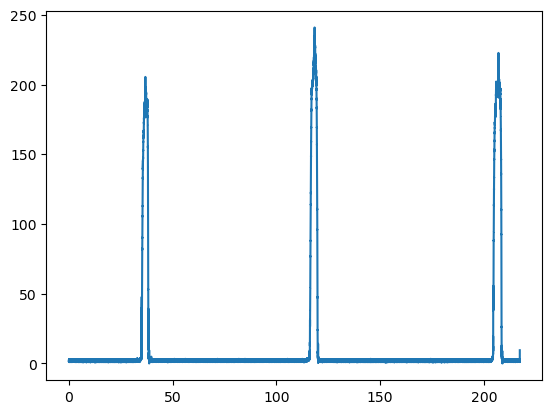

In [4]:
# Print the channel name
print("Channel name: ")
print(acqData.channels[1].name)
# Plot the Force channel
plt.plot(acqData.channels[1].time_index, acqData.channels[1].data)

# Display the plot
plt.show()

In [5]:
# How do we get the channel length and sampling frequency to make our time column?
print("Channel length: ")
print(len(acqData.channels[0].data))
print("Sample rate: ")
print(acqData.channels[0].samples_per_second)

Channel length: 
434518
Sample rate: 
2000.0


In [6]:
# Put the acq data into a pandas dataframe and add a time column

mydf = pd.DataFrame()

# data columns
for ch in acqData.channels:
  mydf[ch.name] = ch.data
    
# time column
# Create list of time values
mytimecol = []
mytimestep = 1.0 / acqData.channels[0].samples_per_second
numsamples = len(acqData.channels[0].data)
for n in range(numsamples):
  mytimecol.append(n * mytimestep)

# See if it worked
print(mytimecol[:10])
    
# Add our time column to the dataframe
mydf['Time'] = mytimecol

mydf.head()

[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045000000000000005]


,EMG RF,Force,Trigger,EMG VL,Torque,Time
0,-0.002136,1.797144,0.055847,-0.009766,1.797144,0.0000
1,0.003357,1.797144,0.055847,-0.011902,1.797144,0.0005
2,0.004272,1.283312,0.055847,-0.010681,1.746980,0.0010
3,-0.000916,2.054059,0.055847,-0.010071,1.674606,0.0015
4,-0.001831,1.283312,0.055847,-0.010071,1.648175,0.0020


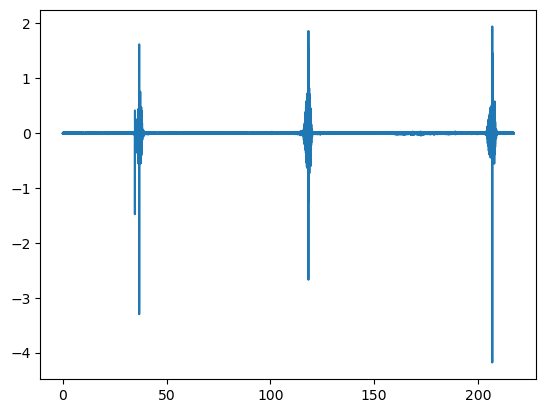

In [7]:
# Display the data

# Define our plot with two arrays for the x and y axes
plt.plot(mydf['Time'], mydf['EMG RF'])
# Display the plot
plt.show()

# An interactive plot lets us find the area of interested
# in our case, the cortical silent period



In [9]:
filtered_df = mydf[mydf['Trigger'] > 3]
print(filtered_df['Trigger'])


73574     3.445129
73575     3.434143
73576     3.434143
73577     3.438110
73578     3.442383
            ...   
413837    3.461304
413838    3.440857
413839    3.460693
413840    3.442383
413841    3.446960
Name: Trigger, Length: 96, dtype: float64


In [14]:
#lovely wee method for extracting the periods of triggers returns a list of indecies of the first trigger over a certain thresholds and will skip the next 200 samples. 
current_trigger_sample = 0
indexes_of_triggers = []
for index,row in filtered_df.iterrows():
    if index > current_trigger_sample + 200:
        indexes_of_triggers.append(index)
        current_trigger_sample = index

In [15]:
print(indexes_of_triggers)

[73574, 236637, 413810]


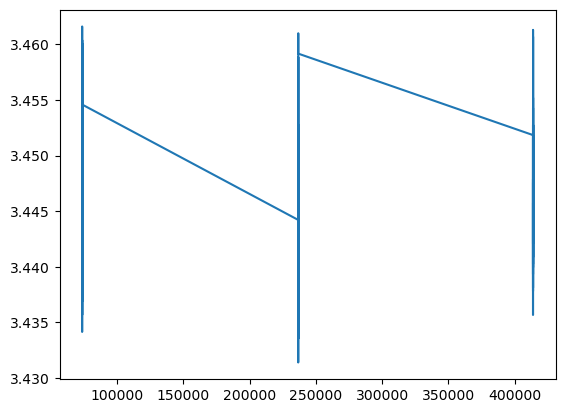

In [10]:
plt.plot(filtered_df['Trigger'])
plt.show()

In [1]:
# Define our plot with two arrays for the x and y axes
plt.plot(mydf['Time'], mydf['Trigger'])
# Display the plot
plt.show()

# Treshold Trigger column to give identical maxima
# We need identical maxima to use the idxmax() function
# idxmax() happens to be the fastest way to find the first of something in a column
mydf['Trigger'] = mydf['Trigger'] > 3

# Define our plot with two arrays for the x and y axes
plt.plot(mydf['Time'], mydf['Trigger'])
# Display the plot
plt.show()

NameError: name 'plt' is not defined

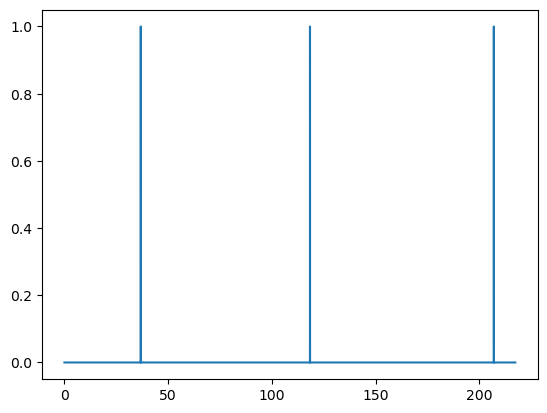

73574


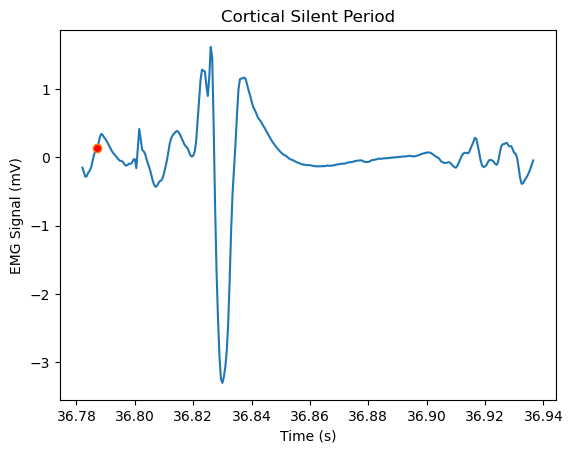

236637


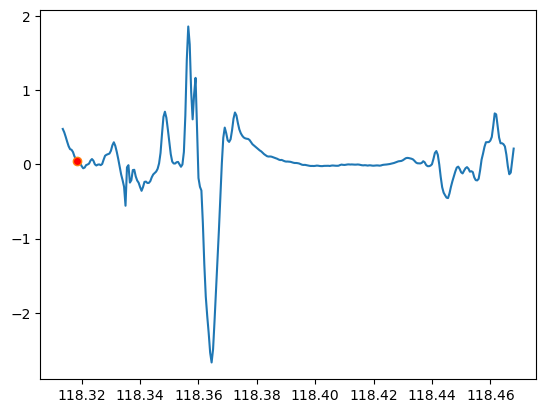

413810


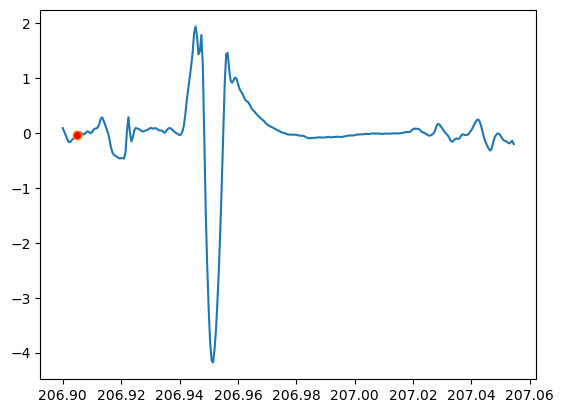

In [12]:
# Limit the axes to zoom in on our areas of interest

# Define our plot with two arrays for the x and y axes
plt.plot(mydf['Time'], mydf['Trigger'])
# Display the plot
plt.show()

# Gating for csp
gatebefore = 10
gateafter = 300


# First trigger
mytrigidx = mydf['Trigger'].idxmax()
print(mytrigidx)
gatestart = mytrigidx - gatebefore
gateend = mytrigidx + gateafter
# Plot
plt.plot(mydf['Time'][gatestart : gateend], mydf['EMG RF'][gatestart : gateend])
# Second data series shows trigger position
plt.plot(mydf['Time'][mytrigidx], mydf['EMG RF'][mytrigidx], marker='o', markerfacecolor='red', markersize=6)
plt.title('Cortical Silent Period')
plt.xlabel('Time (s)')
plt.ylabel('EMG Signal (mV)')
# Display the plot
plt.show()

# Second trigger
mytrigidx = mydf['Trigger'][mytrigidx + 500:].idxmax()
print(mytrigidx)
gatestart = mytrigidx - gatebefore
gateend = mytrigidx + gateafter
# Plot
plt.plot(mydf['Time'][gatestart : gateend], mydf['EMG RF'][gatestart : gateend])
# Second data series shows trigger position
plt.plot(mydf['Time'][mytrigidx], mydf['EMG RF'][mytrigidx], marker='o', markerfacecolor='red', markersize=6)

# Display the plot
plt.show()


# Third trigger
mytrigidx = mydf['Trigger'][mytrigidx + 500:].idxmax()
print(mytrigidx)
gatestart = mytrigidx - gatebefore
gateend = mytrigidx + gateafter
# Plot
plt.plot(mydf['Time'][gatestart : gateend], mydf['EMG RF'][gatestart : gateend])
# Second data series shows trigger position
plt.plot(mydf['Time'][mytrigidx], mydf['EMG RF'][mytrigidx], marker='o', markerfacecolor='red', markersize=6)

# Display the plot
plt.show()

In [ ]:
# Find the start of the CSP.
# This is the peak after the large negative swing

# Truncate the data at the negative peak
# Find the negative peak
negpkidx = mydf['EMG RF'][gatestart : gateend].idxmin()

# Find the positive peak
cspstartidx = mydf['EMG RF'][negpkidx : gateend].idxmax()

# Plot
plt.plot(mydf['Time'][gatestart : gateend], mydf['EMG RF'][gatestart : gateend])
# Second data series shows trigger position
plt.plot(mydf['Time'][mytrigidx], mydf['EMG RF'][mytrigidx], marker='o', markerfacecolor='red', markersize=6)
plt.plot(mydf['Time'][cspstartidx], mydf['EMG RF'][cspstartidx], marker='o', markerfacecolor='green', markersize=6)

# Display the plot
plt.show()

In [ ]:
# Create envelope around signal at end of csp


# Arbitrary start offset to avoid noise at start of csp
envstart = cspstartidx + 50

# Find peaks
from scipy.signal import find_peaks

x = mydf['EMG RF'][envstart : gateend].to_numpy()

peaks, _ = find_peaks(x)
troughs, _ = find_peaks(-x) 

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(troughs, x[troughs], "x")

plt.show()



In [ ]:
# Linear interpolation between peaks and troughs to create crude envelope

interpx = np.linspace(0, gateend - envstart, gateend - envstart)

interppeaks = np.interp(interpx, peaks, x[peaks])
interptroughs = np.interp(interpx, troughs, x[troughs])

#print(interppeaks)

plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(troughs, x[troughs], "x")
plt.plot(interpx, interppeaks)
plt.plot(interpx, interptroughs)

plt.show()


In [ ]:
#Remove peaks and troughs that cause the envelope to shrink with time.. we know it expands

lastgood = 0.0
thisone = 0.0
nextone = 0.0
goodpeaks = np.array(peaks[0]) #first peak must be good surely?

lastgood = x[peaks[0]] - interptroughs[peaks[0]]
for i in (range(1, len(peaks), 1)):
    # if this peak - corresponding point in -ve peak interpolation is larger than
    # the difference for the last good peak 
    # put in in goodpeaks and put the value in lastgood
    nextone = x[peaks[i]] - interptroughs[peaks[i]]
    if lastgood > nextone :   
      pass 
      #print(lastgood, " > ", nextone)
    else:
      goodpeaks = np.append(goodpeaks, peaks[i])
      #print(lastgood, " < ", nextone)
      lastgood = nextone

print("good peaks: ", goodpeaks)

#Addition
interppeaks = np.interp(interpx, goodpeaks, x[goodpeaks])
goodtroughs = np.array(troughs[0])
lastgood = interppeaks[troughs[0]] - x[troughs[0]] 


for i in (range(1, len(troughs), 1)):
    nextone = interppeaks[troughs[i]] - x[troughs[i]]
    if lastgood < nextone :  
      goodtroughs = np.append(goodtroughs, troughs[i])
      lastgood = nextone

print("good troughs: ", goodtroughs)

#addition:
interptroughs = np.interp(interpx, goodtroughs, x[goodtroughs])
plt.plot(x)
plt.plot(goodpeaks, x[goodpeaks], "o")
plt.plot(goodtroughs, x[goodtroughs], "o")
plt.plot(interpx, interppeaks)
plt.plot(interpx, interptroughs)

plt.show()

# Note this loses the trough at 102ish because we have not updated interppeaks, How to avoid this?
# Maybe we need to do the interpolation as we go and ensure the interpolation is ahead of the current point?
# Try with and without reinterpolating and keep if passes either?

In [ ]:
# A spline fit to the peaks and another to the troughs
 # looks good: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline

# Plot the difference of the two spline fits
from scipy.interpolate import CubicSpline
goodpeaksspline = CubicSpline(goodpeaks,x[goodpeaks],bc_type= "natural")
goodtroughsspline = CubicSpline(goodtroughs,x[goodtroughs], bc_type = "natural")

plt.plot(x)
plt.plot(goodpeaks, x[goodpeaks], "o")
plt.plot(goodtroughs, x[goodtroughs], "o")
plt.plot(interpx, goodpeaksspline(interpx))
plt.plot(interpx, goodtroughsspline(interpx))
plt.show()


In [ ]:
#now to plot the difference of the two:
splinedifference = (goodpeaksspline(interpx) + goodtroughsspline(interpx))/2
plt.plot(x)
plt.plot(goodpeaks, x[goodpeaks], "o")
plt.plot(goodtroughs, x[goodtroughs], "o")
plt.plot(interpx, goodpeaksspline(interpx))
plt.plot(interpx, goodtroughsspline(interpx))
plt.plot(interpx,splinedifference)
plt.show()


In [ ]:
#lets add an arbitrary threshold that would mark baseline motor activity
threshold = .035
plt.plot(x)
plt.plot(goodpeaks, x[goodpeaks], "o")
plt.plot(goodtroughs, x[goodtroughs], "o")
plt.plot(interpx, goodpeaksspline(interpx))
plt.plot(interpx, goodtroughsspline(interpx))
plt.plot(interpx,splinedifference)
plt.axhline(y=threshold, color='black', linestyle='--')
plt.show()
# now plotting on top the absolute value of the envelope
EnvelopeAbsoluteValue = (abs(goodpeaksspline(interpx)) + abs(goodtroughsspline(interpx)))
threshold = .4 
plt.plot(x)
plt.plot(goodpeaks, x[goodpeaks], "o")
plt.plot(goodtroughs, x[goodtroughs], "o")
plt.plot(interpx, goodpeaksspline(interpx))
plt.plot(interpx, goodtroughsspline(interpx))
plt.plot(interpx,EnvelopeAbsoluteValue)
plt.axhline(y=threshold, color='black', linestyle='--')
plt.show()

# here we can say that the splined difference crossed the threshold at around 75 ms
# Another plot underneath which will display the absolute value of the envelope size, stacked graphs. 